In [1]:
import numpy as np
import tensorflow as tf
import srez_model as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = tf.placeholder(tf.float32, [100, 28, 28, 1], "input")
Y_ = tf.placeholder(tf.float32, [100, 10], "true_lable")
model1 = sm.Model('cnn-1', X)

In [3]:
model1.get_output()

<tf.Tensor 'input:0' shape=(100, 28, 28, 1) dtype=float32>

In [4]:
model1 = model1.add_conv2d(4, mapsize = 5, stddev_factor = 2.0)
model1 = model1.add_relu()
model1.get_output()

Instructions for updating:
Colocations handled automatically by placer.


<tf.Tensor 'cnn-1_L003/Relu:0' shape=(100, 28, 28, 4) dtype=float32>

In [5]:
model1 = model1.add_conv2d(8, mapsize = 5, stride = 2, stddev_factor = 2.0)
model1 = model1.add_relu()
model1.get_output()

<tf.Tensor 'cnn-1_L005/Relu:0' shape=(100, 14, 14, 8) dtype=float32>

In [6]:
model1 = model1.add_conv2d(12, mapsize = 4, stride = 2, stddev_factor = 2.0)
model1 = model1.add_relu()
model1.get_output()

<tf.Tensor 'cnn-1_L007/Relu:0' shape=(100, 7, 7, 12) dtype=float32>

In [7]:
model1 = model1.add_flatten()
model1 = model1.add_dense(200, stddev_factor = 2.0)
model1 = model1.add_relu()
model1.get_output()

<tf.Tensor 'cnn-1_L010/Relu:0' shape=(100, 200) dtype=float32>

In [8]:
model1 = model1.add_dense(10)
model1.get_output()

<tf.Tensor 'cnn-1_L011/add:0' shape=(100, 10) dtype=float32>

In [9]:
Ylogits = model1.get_output()
Y = tf.nn.softmax(Ylogits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
tf.global_variables()

[<tf.Variable 'cnn-1_L002/weight:0' shape=(5, 5, 1, 4) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L002/bias:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L004/weight:0' shape=(5, 5, 4, 8) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L004/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L006/weight:0' shape=(4, 4, 8, 12) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L006/bias:0' shape=(12,) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L009/weight:0' shape=(588, 200) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L009/bias:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L011/weight:0' shape=(200, 10) dtype=float32_ref>,
 <tf.Variable 'cnn-1_L011/bias:0' shape=(10,) dtype=float32_ref>]

In [11]:
((train_data, train_labels),
 (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()


train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)  # not required

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)  # not required

In [12]:
def get_batch(size):
    batch_loc = np.random.randint(60000, size=size)
    train_bat_lab = np.zeros((size,10))
    train_bat_lab[np.arange(size), train_labels[batch_loc]] = 1
    train_bat_im = train_data[batch_loc]
    return np.reshape(train_bat_im,[size, 28, 28, 1]), train_bat_lab

In [13]:
import math
step = tf.placeholder(tf.int32,name= "step")
lr = 0.0001 +  tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

In [14]:
init = tf.global_variables_initializer()
sess = tf.Session()
writer = tf.summary.FileWriter("logs/", sess.graph)
sess.run(init)

In [15]:
import time
def train_process(epochs, batch_size):
    start_time = time.time()
    train_log = []
    train_time = 0
    while train_time<epochs:
        batch_X, batch_Y = get_batch(batch_size)
        a = sess.run(accuracy, feed_dict = {X:batch_X, Y_:batch_Y, step: train_time})
        train_log.append(a)
        #print("epoch: "+str(train_time)+", accuracy: "+str(a))
        train_time+=1
        sess.run(train_step, feed_dict={X:batch_X, Y_:batch_Y, step: train_time})
    plt.figure(figsize = (16, 10))
    plt.plot(train_log)
    plt.title("Training Accuracy")
    plt.show()
    print("training time:"+ str(time.time() - start_time)+" seconds")
    return train_log

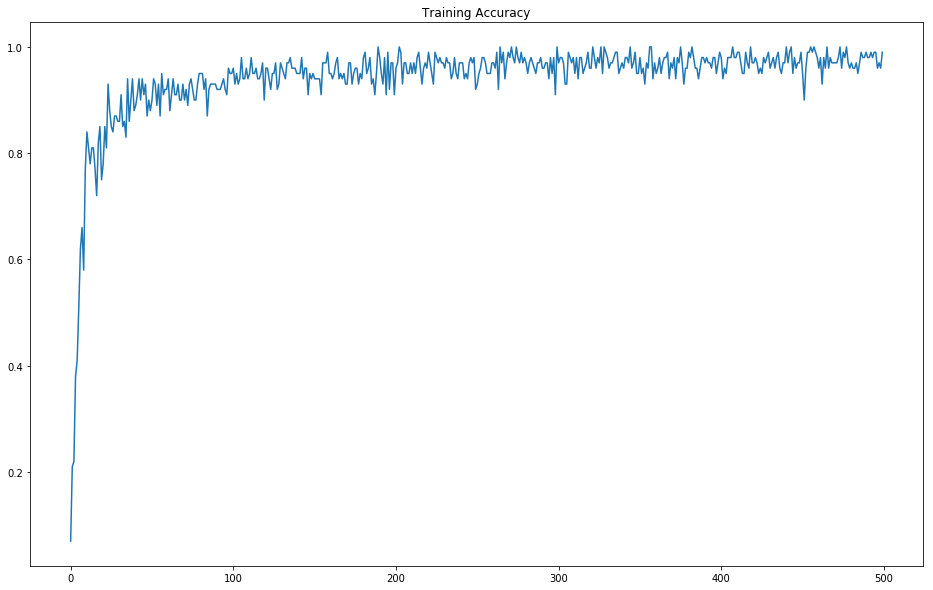

training time:25.914833784103394 seconds


In [16]:
train_log = train_process(500, 100)

In [17]:
eval_lab = np.zeros((100,10))
eval_lab[np.arange(100),eval_labels[:100]] = 1
eval_im = np.reshape(eval_data[:100][:][:][:], [100, 28, 28 ,1])
print(sess.run(accuracy, feed_dict = {X:eval_im, Y_:eval_lab}))

1.0
